# Analyzing Sparkify Churn

Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals.

In the new economy (which provides unprecedented choice, and instant and global access to products and information) churn rate determines business earnings and growth. A firm has to earn and re-earn every day the loyalty of its customers.

The prediction process is heavily data driven and often utilizes advanced machine learning techniques. In this post, we'll take a look at a customer dataset for  a fictitious music service called Sparkify. We will do a complete walk thru of loading in the data typically used, do some preliminary analysis of that data, and generate churn prediction models - all with PySpark and its machine learning frameworks. 

The data we are given has a full size of 12GB that is raw and unclean. We will be working with a smaller subset of this data which is around 128GB. Due to the size of the full dataset (12GB) we will perform our analysis on a tiny subset (128MB) of the data available in this local notebook. Later in another section will transfer all the models and full dataset to a AWS EMR instance in the cloud and see what we learned here on how our model prediction performs on a more bigger scale.

First we need to start by importing our libraries.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, isnull

from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.types import StringType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

import matplotlib.pyplot as plt


# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

#pd.options.display.mpl_style = 'default'

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn analysis") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '45731'),
 ('spark.driver.host', '90349234897e'),
 ('spark.app.name', 'Sparkify Churn analysis'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1565364227763'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load

As mentioned before we will load a subset of the data called  `mini_sparkify_event_data.json` using the Spark read.json function.

In [4]:
#For Cloud Spark analysis on FULL set of data
#path = 'hdfs://xx-some-s3-bucket-path-here'

#For Local Spark analysis on subset of data
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

# Clean Dataset

After loading we will check our dataset, make corrections for invalid or missing data, ie. records without userids or sessionids. 

In [5]:
#Take a look at the columns in dataset
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We see we have 18 columns of attributes (12 string, 6 of long or double type) that describe Sparkify's customer experience as they use the music streaming app ranging from info describing the music they listen to, ratings they gave all the way to administrative usage on users movement from the various monetary models of free and paid tiers. The movement from a paid to a free or worse cancelling of their service is what we are most concerned with because armed with good predictions of these situations Sparkify can invest efforts to preempt these cases from ever happening.

In [6]:
#Look at a sample of the column data:
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [7]:
#Look at the total records in dataset:
user_log.count()

286500

In [8]:
user_log.distinct().count()

286500

Seems like the total rows is 286500, based on the summary above we can see some columns (9) have all values in their rows:

Columns: auth, itemInSession, level, method, page, sessionId, status, ts, userId


In [9]:
#| summary|   auth|itemInSession| level|method|   page| sessionId| status|     ts|  userId|
#+-------+--------+-------------+------+------+-------+----------+-------+-------+--------+
#|  count| 286500|       286500|286500|286500| 286500|    286500| 286500| 286500|  286500|

And some columns (9) have less then the full values in their rows:

Columns: artist, firstName, gender, lastName, length, location, registration, song, userAgent

In [10]:
#|summary| artist|firstName|gender|lastName|  length|location|registration|   song| userAgent|
#+-------+------+---------+------+--------+--------+---------+------------+-------+----------+
#|  count|228108|   278154|278154|  278154|  228108|  278154|      278154| 228108|     278154|

This columns with less then 286500 entries can be further sub divided into only two groups

Seems like we don't have any missing columns when it comes to rows about user info

In [11]:
#Columns about user data:
#|summary|firstName|gender|lastName|location|registration| userAgent|
#+-------+---------+------+--------+--------+------------+----------+
#|  count|  278154|278154|  278154|  278154|      278154|    278154|

Seems like we don't have any missing columns in the song records when user is playing music

In [12]:
#Columns about song data:
#|summary| artist|  length|   song|
#+-------+------+--------+-------+
#|  count|228108|  228108| 228108|

Checking for invalid or missing records without userids or sessionids.

In [13]:
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [14]:
user_log.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [15]:
user_log.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



Seems like there is 58300+ records (286500 - 228108) that don't have an 'artist' associated with it. This can make sense if the session record is referring to a state that doesn't involve playing a song (ie. Add friend, Help, Settings, Administrative app use...)

Seems we have Nulls and blanks all over this dataset. We probably don't want to just blindly delete the rows that have 'blanks' becauase, as we can see from above, we can still derive information from the rows that don't have 'artist' for example, which are the rows that pertain to users session that is rich in user experience data. So we will concentrate on finding the columns that have Nulls/NaNs and fill them since we need a dataset with no nulls for our machine model to work probably later on.

In [16]:
#Do a preliminary search for columns with Null's
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [17]:
#Seems like these Null's are in the columns with type 'string', so replace with a character of '0' for now
user_log = user_log.na.fill('0')

In [18]:
#Check again to see the what columns are left not 'filled' yet
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0| 58392|    0|       0|     0|   0|        8346|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
#Looking at the column types we can see these are numeric type (long, double..etc), so fill with int 0 (zero)
user_log = user_log.na.fill(0)

In [20]:
#Final check to see if any columns have Nulls left
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [21]:
user_log = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [22]:
user_log.count()

286500

Looks good, we have cleaned out any Nulls from our dataset.

In [23]:
user_log.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [24]:
user_log.filter(user_log["userId"] == "").count()

8346

We see we have over 8300 rows that don't have a 'userid' associated with it. Note, these blanks (ie. '') must have a different meaning in the dataset then our standard nulls we found before. They were put in there deliberately to indicate something. Lets do some investigation on this.

In [25]:
user_log.filter(user_log["userId"] == "").filter(user_log.page == 'Submit Downgrade').count()

0

In [26]:
user_log.filter(user_log["userId"] == "").filter(user_log.page == 'Cancellation Confirmation').count()

0

Users with a blank user but have sessions might be users trying out the service before signing up or error entries. Filter out records that have blank userids as that doesn't make sense for our purposes since we are only interested in userids that already in the paid model dropping to free or cancel. 

In [27]:
user_log_valid = user_log.filter(user_log["userId"] != "")

In [28]:
user_log_valid = user_log_valid.dropDuplicates()

In [29]:
user_log_valid = user_log_valid.dropna(how = "any")

In [30]:
user_log_valid.count()

278154

In [31]:
pd.DataFrame(user_log_valid.take(5), columns=user_log_valid.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,The Futureheads,Logged In,Ainsley,F,80,Farley,120.81587,free,"McAllen-Edinburg-Mission, TX",PUT,NextSong,1538304455000,187,Robot,200,1538373133000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78
1,O'Rosko Raricim,Logged In,Madison,F,74,Morales,90.56608,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1536287099000,222,Terre Promise,200,1538384924000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",25
2,Morgan Page,Logged In,Panav,M,23,Myers,235.54567,paid,"Morgantown, WV",PUT,NextSong,1538239045000,237,Strange Condition,200,1538394878000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15
3,0,Logged In,Jaleel,M,61,Maldonado,0.00000,free,"Boulder, CO",GET,Roll Advert,1537890437000,208,0,200,1538402815000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,59
4,0,Logged In,Jaleel,M,69,Maldonado,0.00000,free,"Boulder, CO",GET,Home,1537890437000,208,0,200,1538403354000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,59


As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings and so we filtered them out. When we have empty string user ids one possible reason is it represents users who have not signed up yet or who are signed out and are about to log in.

# Exploratory Data Analysis

Now that we have filtered and cleaned the data, lets do some further data exploration analysis on it. Let's start with looking at the general distribution of the data (ie. describe function in Spark).

In [32]:
user_log_valid.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,278154,2.444687580815214,88.82864984596488,!!!,ÃÂlafur Arnalds
auth,278154,None,None,Cancelled,Logged In
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,278154,114.89918174824018,129.85172939949015,0,1321
lastName,278154,None,None,Adams,Wright
length,278154,204.29554184588397,131.2734010431265,0.0,3024.66567
level,278154,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


We can use the Pandas library to examine correlations between the numeric columns by generating scatter plots of them. Since the data is quite large we will just use 20% of the data to see what we get.

In [33]:
#Quick look at the datatypes as a reference so can check back after looking at the correlation matrix
user_log_valid.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [34]:
user_log.select("userId").distinct().count()

226

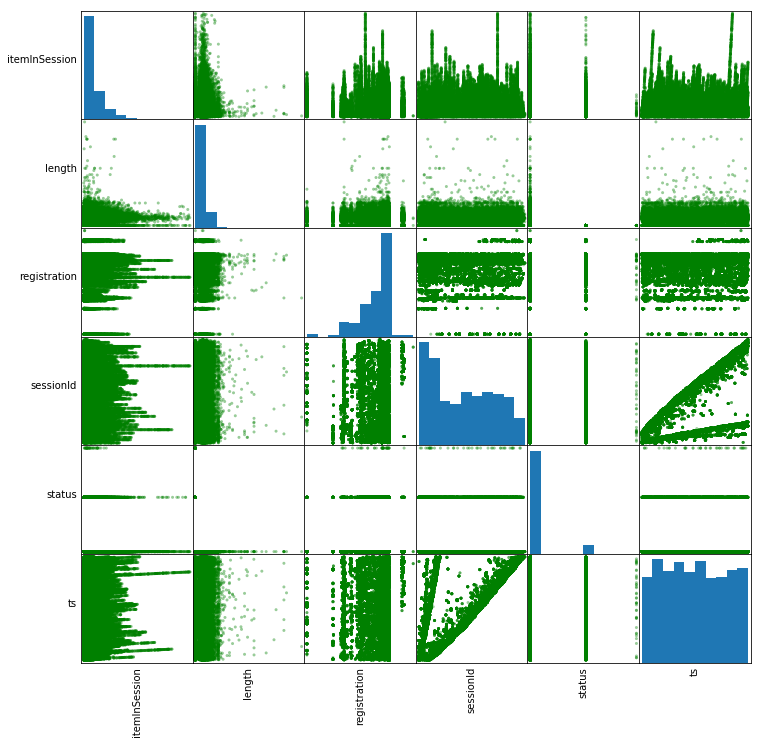

In [35]:
numeric_features = [t[0] for t in user_log_valid.dtypes if t[1] == 'bigint' or t[1] == 'double']

sampled_data = user_log_valid.select(numeric_features).sample(False, 0.20).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12), color='green', alpha=0.4);

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Looks like we have some information on how length, ItemInSession ts, and sessionId relate to each other. We can keep these in for our analysis. One relation seems highly correlated (ie. sessionid & ts). The one thing that is interesting about this graph is it seems to have two highly correlated regions. This might be an indication for earlier session's was designated for FREE tiered users and the other might represent users that signed up as paid from the beginning and got a different (higher) session id. Of course, since there is no dataset readme file that explains each column this is only pure spectulation. On the other hand,  we have other columns that would be interesting to see in comparison with some the columns above that are not on the grid chart above. Example, columns that are numeric but are simply categorical really don't tell us anything on if we can't look at how users interacted with the pages and more specifically when they clicked to down grade or cancel there service. It might be more useful to revisit this later if we perform a 'one-hot encoding' on the 'page' column and see how it relates to the sessions.

In the meantime, we will continue and look at some other distributions, example at males vs. females in our dataset.

In [36]:
#Number of female users we have
user_log_valid.filter(user_log_valid.gender == 'F').select('userId', 'gender').count()#dropDuplicates().count()

154578

In [37]:
#Number of male users we have
user_log_valid.filter(user_log_valid.gender == 'M').select('userId', 'gender').count()#dropDuplicates().count()

123576

Seems like females are slightly the more dominate gender at ~56% representation of the data. Note, these numbers represent total RECORDS and not indvidual userids as each row is an activity event of some particular user. To find the distinct users in each group we can do the following:

In [38]:
user_log_valid.filter(user_log_valid.gender == 'F').select('userId', 'gender').distinct().count()

104

In [39]:
user_log_valid.filter(user_log_valid.gender == 'M').select('userId', 'gender').distinct().count()

121

And we can actually see the male gender was the more dominate with ~54% in our subset population. What this tells us is that females, while only representing less then half of our sample (46%) they generated more user activity then males.

Let's now look at the pages a user can visit and interact with on the app.

In [40]:
#Display sorted unique values in the 'pages' column that the user could be in:
user_log_valid.select('page').dropDuplicates().sort('page').show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



We notice there are some pages that can give us some stats that we analyze for our churn metrics (ie. Downgrade, Submit Downgrade, Submit Registration, Submit Upgrade, Upgrade...etc.). Let's first look at the typical user and see what type of activity they experience on the app and see if there is a pattern we can exploit in our churn definition.

Aggregate all records when user was playing music by the hour of the day

In [41]:
#Create user defined function and get hour element
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [42]:
#Add hour element as a new column
user_log = user_log_valid.withColumn("hour", get_hour(user_log.ts))

In [43]:
user_log.schema

StructType(List(StructField(artist,StringType,false),StructField(auth,StringType,false),StructField(firstName,StringType,false),StructField(gender,StringType,false),StructField(itemInSession,LongType,true),StructField(lastName,StringType,false),StructField(length,DoubleType,false),StructField(level,StringType,false),StructField(location,StringType,false),StructField(method,StringType,false),StructField(page,StringType,false),StructField(registration,LongType,true),StructField(sessionId,LongType,true),StructField(song,StringType,false),StructField(status,LongType,true),StructField(ts,LongType,true),StructField(userAgent,StringType,false),StructField(userId,StringType,false),StructField(hour,StringType,true)))

In [44]:
user_log.count()

278154

We can see our last column of 'hour' (hour,StringType,true)

In [45]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [46]:
#Show all the records for each hour of the day
songs_in_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



In [47]:
#Convert to a Pandas DataFrame
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

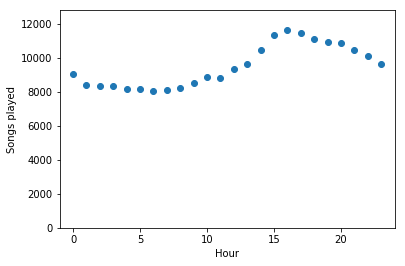

In [48]:
#Create Scatter plot once in DataFrame
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0.0, 1.1 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

We can see the app usage for playing music peaks out at around 4PM (1600 hours) on average on any day.

### Define Churn

Now that we have done some preliminary analysis, let's create a column `Churn` to use as the label for our machine learning model. We can start looking at the `Cancellation Confirmation` events to define our churn, which happen for both paid and free users. We can also look at the `Downgrade` events to better fine tune our indication of what 'churn' means.

In [49]:
#Subset columns to better analyze the user experience
interest_columns = ['ts', 'userId', 'firstname', 'page', 'song']

In [50]:
#Find total users that hit the 'downgrade' page
user_log.select(interest_columns).where(user_log.page == 'Downgrade').count()

2055

In [51]:
#Lets look at some of these users records that hit the 'downgrade' page
user_log.select(interest_columns).where(user_log.page == 'Downgrade').show()

+-------------+------+---------+---------+----+
|           ts|userId|firstname|     page|song|
+-------------+------+---------+---------+----+
|1539317371000|    85|  Brayden|Downgrade|   0|
|1539695328000|     9|    Micah|Downgrade|   0|
|1539848725000|    10|   Brycen|Downgrade|   0|
|1540460941000|    39|   Payton|Downgrade|   0|
|1541619633000|    25|  Madison|Downgrade|   0|
|1541740973000|    38|   Calvin|Downgrade|   0|
|1542181014000|    29|    Kaleb|Downgrade|   0|
|1542196058000|    85|  Brayden|Downgrade|   0|
|1542355785000|    74|  Ashlynn|Downgrade|   0|
|1542577498000|     9|    Micah|Downgrade|   0|
|1538746409000|200023|  Katiana|Downgrade|   0|
|1540470333000|200023|  Katiana|Downgrade|   0|
|1542981780000|300011|   Emilia|Downgrade|   0|
|1540871379000|    49| Christan|Downgrade|   0|
|1540936248000|   103|    Piper|Downgrade|   0|
|1541477025000|   128|    Caleb|Downgrade|   0|
|1541620469000|    92|    Riley|Downgrade|   0|
|1541699332000|    42|   Dillyn|Downgrad

In [52]:
#We will view one user (userid=30, Colin) to see what their experience using the 'Downgrade' page
user_log.select(['ts',"userId", "firstname", "page",
                 "level", "song"]).where(user_log.userId == "30").orderBy("ts").collect()

[Row(ts=1538352117000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Rockpools'),
 Row(ts=1538352394000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Time For Miracles'),
 Row(ts=1538352676000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Harder Better Faster Stronger'),
 Row(ts=1538352899000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Passengers (Old Album Version)'),
 Row(ts=1538352905000, userId='30', firstname='Colin', page='Add to Playlist', level='paid', song='0'),
 Row(ts=1538353084000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Fuck Kitty'),
 Row(ts=1538353218000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Jade'),
 Row(ts=1538353441000, userId='30', firstname='Colin', page='NextSong', level='paid', song='So-Called Friends'),
 Row(ts=1538353687000, userId='30', firstname='Colin', page='NextSong', level='paid', song='Represent'),
 Ro

In [53]:
#Find total users that hit the 'cancelled' confirmation page
user_log.select(interest_columns).where(user_log.page == 'Submit Downgrade').count()

63

In [54]:
#Lets look at some of these users records
user_log.select(interest_columns).where(user_log.page == 'Submit Downgrade').show()

+-------------+------+---------+----------------+----+
|           ts|userId|firstname|            page|song|
+-------------+------+---------+----------------+----+
|1542989412000|100016|   Landon|Submit Downgrade|   0|
|1538753821000|200023|  Katiana|Submit Downgrade|   0|
|1539330539000|200025|    Elias|Submit Downgrade|   0|
|1538995454000|    30|    Colin|Submit Downgrade|   0|
|1542290890000|   140|   Lucero|Submit Downgrade|   0|
|1541541339000|200023|  Katiana|Submit Downgrade|   0|
|1539239742000|    11|      Zoe|Submit Downgrade|   0|
|1540235073000|    74|  Ashlynn|Submit Downgrade|   0|
|1540738746000|    24|  Garrett|Submit Downgrade|   0|
|1542419388000|    39|   Payton|Submit Downgrade|   0|
|1540567296000|200020|   Keegan|Submit Downgrade|   0|
|1540236417000|300002|   Lindyn|Submit Downgrade|   0|
|1542091077000|    49| Christan|Submit Downgrade|   0|
|1538516445000|    38|   Calvin|Submit Downgrade|   0|
|1539106390000|100018|   Jayden|Submit Downgrade|   0|
|154267149

In [55]:
#We will view one user (userid=61, Parker) to see what their experience using the 'Submit Downgrade' page
user_log.select(['ts',"userId", "firstname", "page",
                 "level", "song"]).where(user_log.userId == "61").orderBy("ts").collect()

[Row(ts=1538445366000, userId='61', firstname='Parker', page='Home', level='free', song='0'),
 Row(ts=1538446343000, userId='61', firstname='Parker', page='NextSong', level='free', song='Point And Shoot (Explicit Album Version)'),
 Row(ts=1538446593000, userId='61', firstname='Parker', page='NextSong', level='free', song='When A Man Loves A Woman'),
 Row(ts=1538446766000, userId='61', firstname='Parker', page='NextSong', level='free', song='Ungod'),
 Row(ts=1538447229000, userId='61', firstname='Parker', page='NextSong', level='free', song='Matricide'),
 Row(ts=1538447549000, userId='61', firstname='Parker', page='NextSong', level='free', song='Simple'),
 Row(ts=1538447555000, userId='61', firstname='Parker', page='Roll Advert', level='free', song='0'),
 Row(ts=1538447903000, userId='61', firstname='Parker', page='NextSong', level='free', song='Close (To The Edit)'),
 Row(ts=1538447904000, userId='61', firstname='Parker', page='Thumbs Up', level='free', song='0'),
 Row(ts=1538448231000

In [56]:
#Find total users that hit the 'cancelled' confirmation page
user_log.select(interest_columns).where(user_log.page == 'Cancellation Confirmation').count()

52

In [57]:
#Lets look at some of these users records that hit the 'cancellation confirmation' page
user_log.select(interest_columns).where(user_log.page == 'Cancellation Confirmation').show()

+-------------+------+---------+--------------------+----+
|           ts|userId|firstname|                page|song|
+-------------+------+---------+--------------------+----+
|1541166424000|   106|   Sophia|Cancellation Conf...|   0|
|1541120964000|200011|  Charles|Cancellation Conf...|   0|
|1539629720000|200001|    Reece|Cancellation Conf...|   0|
|1541340091000|   103|    Piper|Cancellation Conf...|   0|
|1539375441000|   105|Alexander|Cancellation Conf...|   0|
|1542181031000|    29|    Kaleb|Cancellation Conf...|   0|
|1538695038000|100024| Jonathon|Cancellation Conf...|   0|
|1539465584000|    17|    Kayla|Cancellation Conf...|   0|
|1540062847000|100017|    James|Cancellation Conf...|   0|
|1543009344000|300001| Antonina|Cancellation Conf...|   0|
|1539761972000|    51|    Ethan|Cancellation Conf...|   0|
|1539475237000|100023|   Sawyer|Cancellation Conf...|   0|
|1542356278000|200016|Charlotte|Cancellation Conf...|   0|
|1541153274000|200018|    Saulo|Cancellation Conf...|   

In [58]:
#We will view one user (userid=122, Molly) to see what their experience using the 'Cancellation Confirmation' page
user_log.select(['ts',"userId", "firstname", "page",
                 "level", "song"]).where(user_log.userId == "122").orderBy("ts").collect()

[Row(ts=1538657235000, userId='122', firstname='Molly', page='Home', level='free', song='0'),
 Row(ts=1538657236000, userId='122', firstname='Molly', page='Logout', level='free', song='0'),
 Row(ts=1539173538000, userId='122', firstname='Molly', page='Home', level='free', song='0'),
 Row(ts=1539173664000, userId='122', firstname='Molly', page='NextSong', level='free', song='Old School Rules (Album Version)'),
 Row(ts=1539173824000, userId='122', firstname='Molly', page='NextSong', level='free', song='Kiss With A Fist'),
 Row(ts=1539173955000, userId='122', firstname='Molly', page='NextSong', level='free', song='Serve Chilled'),
 Row(ts=1539174264000, userId='122', firstname='Molly', page='NextSong', level='free', song='Mona Lisa (When The World Comes Down)'),
 Row(ts=1539174458000, userId='122', firstname='Molly', page='NextSong', level='free', song='The Memory Remains'),
 Row(ts=1539174569000, userId='122', firstname='Molly', page='Roll Advert', level='free', song='0'),
 Row(ts=153988

We can see a total of 115 (52+63) user events that either submitted to downgrade or cancel their service. Additionally, we see 2055 user events that visited the downgrade page. These could be curious page visits, errors, or people actually thinking of downgrading their service. In either case, unless we do some deeper analysis on what happens next in all these user cases (ie. did they actually go thru with the downgrade from paid to free) we would only be speculating. In this case, since this advance deeper analysis is out of scope for this project we will leave that for another time.  Let's see if we can make some functions to view the 115 events easier.

In [59]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [60]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [61]:
add_churn_flags = udf(lambda x,y : x+y, IntegerType())

Now we will use these functions to create new columns of ‘churn’. We will make two such columns to categorize two different situations a user can move into. These are as follows:

- One is 'submit downgrading' their service from paid->free which we will call 'churn_down'
- One for 'cancelling' their service from paid or free to cancelled which we will call 'churn_off'
- And another just called 'churn' which will be our combination of the two above and will see if it makes a good label

In [62]:
user_log = user_log.withColumn("churn_down", flag_downgrade_event("page"))

In [63]:
user_log = user_log.withColumn("churn_off", flag_cancellation_event("page"))

In [64]:
user_log = user_log.withColumn("churn", add_churn_flags("churn_down", "churn_off"))

In [65]:
user_log.where(user_log.churn >= "1").count()

115

Note that the 115 events of 'churn' are not all indivdual users. To get that number we need to filter for distinct userids and ultimately do the same for the userids as a whole to get a percentage of 'churn' that is represented in our data.

In [66]:
#Total unique number of users that 'churned'
user_log.select("userId").where(user_log.churn == "1").distinct().count()

92

In [67]:
#Total unique number of users
user_log.select("userId").distinct().count()

225

We find there are 92 users meet our definition of 'churn', by that we mean a unique userid that either actioned a 'downgrade' or canceled' their subscription. As for the rate I am not sure of this calculation but we can see Sparkify has a HIGH churn rate of ~41% (92 churn users/225 total users). We can understand why Sparkify wants to conduct this analysis.

In [68]:
churn_userids = user_log.filter(user_log.churn=="1").select("userId").dropDuplicates()
#churn_users_list = [(i['userId']) for i in churn_userids.collect()]
user_log = user_log.withColumn("churn", user_log.userId.isin([(i['userId']) for i in churn_userids.collect()]))

In [69]:
user_log.where(user_log.churn == True).count()

140415

In [70]:
user_log.where(user_log.churn == False).count()

137739

In [71]:
user_log.count()

278154

As we can see above we have quite an even labeled dataset with 50.4% of the labels indicating 'churn' (or 1). Note, we will have to think how to handle this when we come to the encoding of this column. Reason is, if we were to blindly run an Indexer (ie. StringIndexer) on this column we might not get '1' to mean churn. This is because StringIndexer maps a string column of labels to an ML column of label indices. The indices are in the set of 0 to numLabels, ordered by label frequencies. The most frequent label gets index 0. So in our case above, churn (which is True or '1') we would get the label of '0' for these columns and to us that would confuse some that the label means 'not-churned'. Which wouldn't be the case, so we need to keep this in mine when we get to our conclusions and make our interpretations.

In [72]:
#Confirm we see our new flagged columns at the end
user_log.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = false)
 |-- firstName: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = false)
 |-- length: double (nullable = false)
 |-- level: string (nullable = false)
 |-- location: string (nullable = false)
 |-- method: string (nullable = false)
 |-- page: string (nullable = false)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = false)
 |-- hour: string (nullable = true)
 |-- churn_down: integer (nullable = true)
 |-- churn_off: integer (nullable = true)
 |-- churn: boolean (nullable = false)



### Explore Data
Now we wil perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We will start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's create a window for the range and partition of 'userid's and order it by descending time

In [73]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

Lets apply this windowing to records before a downgrade and after and store those values in a new columns called 'phase_down' and 'phase_off'.

In [74]:
user_log = user_log.withColumn("phase_down", Fsum("churn_down").over(windowval))

We will create another column for tracking the 'phase_off' for the grouping of records before and after user cancels their service.

In [75]:
user_log = user_log.withColumn("phase_off", Fsum("churn_off").over(windowval))

In [76]:
#We will view one user (userid=61, Parker) to see the phase 'Submit Downgrade' column changed in action
user_log.select(["userId", "firstname", "ts", "page", "level", 'churn_down',"churn"]).where(user_log.userId == "61").sort("ts").collect()

[Row(userId='61', firstname='Parker', ts=1538445366000, page='Home', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538446343000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538446593000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538446766000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538447229000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538447549000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538447555000, page='Roll Advert', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538447903000, page='NextSong', level='free', churn_down=0, churn=True),
 Row(userId='61', firstname='Parker', ts=1538447904000, page='Thumbs Up', level='free', c

In [77]:
user_log.select(["userId", "page", "level", 'churn_down',"churn"]).where(user_log.userId == "61").where(user_log.churn_down == "1").sort("ts").collect()

[Row(userId='61', page='Submit Downgrade', level='paid', churn_down=1, churn=True),
 Row(userId='61', page='Submit Downgrade', level='paid', churn_down=1, churn=True)]

I have pulled out the relevant lines where the user 'churned' from paid to free user subscription. 

- Row(userId='61', page='Submit Downgrade', level='paid', churn_down=1, churn=True),
- Row(userId='61', page='Submit Downgrade', level='paid', churn_down=1, churn=True)

Note how the 'churn_down' is relative to only the one line when page is equal to 'submit downgrade' and indicates this user (in this case '61, Parker') has the label of churning. This column 'churn' is more related to the period of records as a whole for this user that happened before and after the downgrading or canclled events. For this reason I will include 'churn_down' this column in the features set and use 'churn' as the label for the machine learning part.

In [78]:
#We will view one user (userid=122, Molly) to see the phase 'Confirm Cancelation' column changed in action
user_log.select(["userId", "firstname", "ts", "page", "level", "churn_off", "churn"]).where(user_log.userId == "122").sort("ts").collect()

[Row(userId='122', firstname='Molly', ts=1538657235000, page='Home', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1538657236000, page='Logout', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539173538000, page='Home', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539173664000, page='NextSong', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539173824000, page='NextSong', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539173955000, page='NextSong', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539174264000, page='NextSong', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539174458000, page='NextSong', level='free', churn_off=0, churn=True),
 Row(userId='122', firstname='Molly', ts=1539174569000, page='Roll Advert', level='free', churn_off=0, chu

I also pulled out the relevant lines regarding the phase change for this user when they canceled their subscription. However I did it for a different illustration then the case of 'phase_down above:

- Row(userId='122', firstname='Molly', ts=1540062022000, page='NextSong', level='paid', churn_off=0, churn=True),
- Row(userId='122', firstname='Molly', ts=1540062049000, page='Settings', level='paid', churn_off=0, churn=True),
- Row(userId='122', firstname='Molly', ts=1540062050000, page='Cancel', level='paid', churn_off=0, churn=True),
- **Row(userId='122', firstname='Molly', ts=1540062068000, page='Cancellation Confirmation', level='paid', churn_off=1, churn=True)**

I mainly wanted to show that the phase 'change' for cancelations usually comes at the end of the users activity. Which makes sense since they are technically not using the service any longer. I felt this as necessary to show as it really doesn't allow for an opportunity for an 'after' phase for the learning model to see a pattern and therefore it would only learning before activity patterns which would be different then the case of downgrading. I assume for this analysis we are looking for patterns in user behaviour  'downgrading' and 'cancelation' before and after these events so which is why I have conbined them into one feature and work with that as the label to define 'churn'. If we wanted to separate specific behaviour on how to identify patterns in only 'downgraded' vs. 'cancelled' users then we would need to separate our churn label into two our more labels (like 'churn_downgrade', 'churn_cancel'...etc.). I will leave that for a more advance analysis if required later on.

In [79]:
#Confirm we see our new flagged columns at the end
user_log.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = false)
 |-- firstName: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = false)
 |-- length: double (nullable = false)
 |-- level: string (nullable = false)
 |-- location: string (nullable = false)
 |-- method: string (nullable = false)
 |-- page: string (nullable = false)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = false)
 |-- hour: string (nullable = true)
 |-- churn_down: integer (nullable = true)
 |-- churn_off: integer (nullable = true)
 |-- churn: boolean (nullable = false)
 |-- phase_down: long (nullable = true)
 |-- phase_off: long (nullable = true)



You can see from above I explored to see if adding two additional columns ('phase_down' & 'phase_off') to represent the division period in the time line for events before some downgrading (or cancelation) page event and after. It seemed these extra columns might play a role if we wanted to explore further on learning before and after pattens on these churned events. I will keep them in the dataset if further analysis is needed later in the project or for a deeper dive requested by Sparkify. For now I will not include them in any 'labels' for our model.

So in the end we have the new columns ('churn_down' & 'churn_off' which might not be the best names) to track the individual user selection which will never be one the same row as there will always be different timestamp for every individual event or page session. We then combined the events into one column ('churn') to track the overall sentiment of service disatisfaction, either downgrading service from paid to free or canceling subscription all together. We then went back and added a 'churn flag' for every userid record. So 'churn' now represents a flag that 'this userid churned' and it attached to every record of that particular userid. While 'churn_down' and 'churn_off' are still pegged to only that specific timestamp record. 

Note, I can use either of the 'churn_down' or 'churn_off' columns in the features for machine learning as the model even thou we have this information technically from the 'page' feature. However, I would like to include this along side the 'page' in the feature to provide the extra 'weighted' indicator feature that would clearly point to the fact this page (ie. submit downgrade or confirm cancelation) should be more important then the rest.

With these definitions, I will make 'churn' the label since we need to indicate the userid as a whole and not just one event in time, since it is the user that we are trying to make a prediction model for and not when a user will churn. As mentioned before, will not be using either of the 'phase_down' or 'phase_off' as it will require a difference model to analyze.

# Feature Engineering

Now that we are somewhat familiar with the data, we will now work on build out the features that seem promising to train our model on. Let's first look at some of the distinct values for some of the columns to get a better understanding what we need to encode.

In [80]:
user_log.select("auth").dropDuplicates().sort("auth").show(5)

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [81]:
user_log.select("level").dropDuplicates().sort("level").show(5)

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [82]:
user_log.select("method").dropDuplicates().sort("method").show(5)

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [83]:
user_log.select("status").dropDuplicates().sort("status").show(5)

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [84]:
user_log.select("registration").dropDuplicates().count()

225

In [85]:
user_log.select("userId").dropDuplicates().count()

225

In [86]:
user_log.select("sessionId").dropDuplicates().count()

2312

In [87]:
user_log.select("sessionId").dropDuplicates().sort("sessionId").show(10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [88]:
user_log.select("userAgent").dropDuplicates().count()

56

In [89]:
user_log.select("itemInSession").dropDuplicates().count()

1311

In [90]:
user_log.select("itemInSession").dropDuplicates().sort("itemInSession").show(10)

+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
|            5|
|            6|
|            7|
|            8|
|            9|
+-------------+
only showing top 10 rows



Since we have a situation where we want to predict what state a user account will be either 'will churn' or will not churn' this leans towards developing a Classification problem. We need to review our dataset and select the columns we would like to use to make this prediction.

In [91]:
user_log.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = false)
 |-- firstName: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = false)
 |-- length: double (nullable = false)
 |-- level: string (nullable = false)
 |-- location: string (nullable = false)
 |-- method: string (nullable = false)
 |-- page: string (nullable = false)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = false)
 |-- userId: string (nullable = false)
 |-- hour: string (nullable = true)
 |-- churn_down: integer (nullable = true)
 |-- churn_off: integer (nullable = true)
 |-- churn: boolean (nullable = false)
 |-- phase_down: long (nullable = true)
 |-- phase_off: long (nullable = true)



From the columns above we will select the ones that will be part of our feature set and then convert them into the necessary vector space we need for machine learning by encoding the columns where applicable. We start with extracting the necessary features from the smaller subset of data, but first we need to do a quick analysis of each column we currently have see why (or why not) we would include it in our learning model feature/label extraction process.

- artist: string (nullable = true)  - not selected, artist played shouldn't by an indication of churn
- auth: string (nullable = true)   - selected!
- firstName: string (nullable = true) - not selected, user name shouldn't play any reason for a user to churn
- gender: string (nullable = true)   - selected!
- itemInSession: long (nullable = true)- not selected, with 1311 different types this might be too many encodings for our ML model
- lastName: string (nullable = true)  - not selected, last name shouldn't play any reason for a user to churn
- length: double (nullable = true)   - selected!
- level: string (nullable = true)   - selected!
- location: string (nullable = true)   - selected!
- method: string (nullable = true)   - selected!
- page: string (nullable = true)   - selected!
- registration: long (nullable = true) - not selected, as this is same data as 'userId'
- sessionId: long (nullable = true) - not selected, with 2312 different types this might be too many encodings for our ML model
- song: string (nullable = true)  - not selected, song played shouldn't by an indication of churn
- status: long (nullable = true)   - selected!
- ts: long (nullable = true)   - not selected, since this is a unique timestamp and therefore can't learn any pattern from this
- userAgent: string (nullable = true)   - selected!
- userId: string (nullable = true)   - selected!
- hour: string (nullable = true)   - selected as hour feature extracted from timestamp can have patterns!
- churn_down: integer (nullable = true) - selected, to give more weight to 'pages'
- churn_off: integer (nullable = true)  - selected, to give more weight to 'pages'
- churn: integer (nullable = true)     - selected, this will be our label
- phase_down: long (nullable = true)   - not selected, this could be used later for deeper modeling to find patterns when users only 'downgrade' their service
- phase_off: long (nullable = true) - not selected, this could be used later for deeper modeling to find patterns when users only 'cancel' their service


So out of the 24 columns above we seem to find 14 columns (13 features + 1 label) to be part our machine learning model.

In [92]:
#Gather the ones that are selected from above
input_data = user_log.select(["userId", "auth", "gender", "location", "length", "userAgent","page", 
                              "level", "method", "status", 'hour', 'churn_down', 'churn_off', 'churn'])

In [93]:
input_data.churn.cast('string')

Column<b'CAST(churn AS STRING)'>

In [94]:
input_data.printSchema()

root
 |-- userId: string (nullable = false)
 |-- auth: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- location: string (nullable = false)
 |-- length: double (nullable = false)
 |-- userAgent: string (nullable = false)
 |-- page: string (nullable = false)
 |-- level: string (nullable = false)
 |-- method: string (nullable = false)
 |-- status: long (nullable = true)
 |-- hour: string (nullable = true)
 |-- churn_down: integer (nullable = true)
 |-- churn_off: integer (nullable = true)
 |-- churn: boolean (nullable = false)



In [95]:
input_data = input_data.withColumn("churn", input_data["churn"].cast(StringType()))

In [96]:
input_data.printSchema()

root
 |-- userId: string (nullable = false)
 |-- auth: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- location: string (nullable = false)
 |-- length: double (nullable = false)
 |-- userAgent: string (nullable = false)
 |-- page: string (nullable = false)
 |-- level: string (nullable = false)
 |-- method: string (nullable = false)
 |-- status: long (nullable = true)
 |-- hour: string (nullable = true)
 |-- churn_down: integer (nullable = true)
 |-- churn_off: integer (nullable = true)
 |-- churn: string (nullable = false)



In [97]:
input_data.filter(input_data.churn == 'true').show()

+------+---------+------+--------------------+---------+--------------------+---------------+-----+------+------+----+----------+---------+-----+
|userId|     auth|gender|            location|   length|           userAgent|           page|level|method|status|hour|churn_down|churn_off|churn|
+------+---------+------+--------------------+---------+--------------------+---------------+-----+------+------+----+----------+---------+-----+
|    25|Logged In|     F|Tampa-St. Petersb...| 90.56608|"Mozilla/5.0 (Mac...|       NextSong| paid|   PUT|   200|   9|         0|        0| true|
|    59|Logged In|     M|         Boulder, CO|      0.0|Mozilla/5.0 (Wind...|    Roll Advert| free|   GET|   200|  14|         0|        0| true|
|    59|Logged In|     M|         Boulder, CO|      0.0|Mozilla/5.0 (Wind...|           Home| free|   GET|   200|  14|         0|        0| true|
|    51|Logged In|     M|Lexington-Fayette...|210.36363|"Mozilla/5.0 (Win...|       NextSong| paid|   PUT|   200|  14|      

# Modeling

So now that we have confirmed features and labels (for now) our next step is to convert the Categoricals into indices and encode them. Then conbine all that with our numeric columns into a Vector so the machine learning model can understand. 

In [98]:
#List of categorical and numeric columns that will still need to be represented in our vector space
categoricalCols = ['userId', 'auth', 'gender', 'location', 'userAgent', 'page', 
                   'level', 'method', 'status', 'hour', 'churn_down', 'churn_off']
numericCols = ['length']
stages = []

In [99]:
for categoricalCol in categoricalCols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_idx')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_idx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_idx]

assemblerInputs = [c + "classVec" for c in categoricalCols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("skip")
stages += [assembler]

What we did above was we indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We then use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

Now that all the parts are gathered in 'stages' we will now create a pipeline to convert the features of string type to numeric and feed in a list of columms to convert and transform from the 'input_data' dataframe. The result is the orginal dataset with additional column of vector type (called 'features') of our features in numerical which is a combination of our encoded features and of course our 'label' which is just our original 'phase_down' but now as double type.

In [ ]:
from pyspark.ml import Pipeline

cols = input_data.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(input_data)
piped_data = pipelineModel.transform(input_data)
selectedCols = ['label', 'features'] + cols
piped_data = piped_data.select(selectedCols)

In [ ]:
piped_data.printSchema()

Now, recall we had monitor the the value what was given during the passing of label column thru StringIndexer. We can see that the label is equal to ONE (1.0) when our churn label is actually 'false'. We need to reverse this.

In [ ]:
piped_data.filter(piped_data.churn == 'false').select('features', 'churn', 'label').show()#dropDuplicates().count()
#piped_data.show()#dropDuplicates().count()

In [ ]:
#Create a UDF to reverse the label value and change the datatype to 'double'
change_churn_val = udf(lambda x: 0.0 if x == 1.0 else 1.0, DoubleType())
piped_data = piped_data.withColumn("label", change_churn_val("label"))

In [ ]:
piped_data.filter(piped_data.churn == 'false').select('features', 'churn', 'label').dropDuplicates().show()

In [ ]:
piped_data.head(1)

As we can see in the 'features' column we have SparseVector that is combination of the input_data columns:

- features=SparseVector(442, {154: 1.0, 224: 1.0, 225: 1.0, 301: 1.0, 353: 1.0, 400: 1.0, 413: 1.0, 415: 1.0, 419: 1.0, 439: 1.0, 440: 1.0}

In [ ]:
#Create a dataset with only the features and the label of churn
piped_data = piped_data.select('features', 'label')
piped_data.printSchema()

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
#Split into training and testing datasets
train, test = piped_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
#Split training into train and validation datasets
train, validation = train.randomSplit([0.8, 0.2], seed=42)

In [ ]:
print("Train Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
print("Validation Dataset Count: " + str(validation.count()))

Now that we have our dataset split up we will now define a model for training. As mentioned before, since we are trying to make a binary conclusion on our users outcome we will create a classification model, more specifically we can start with a Logistic Regression model and work from there. First we need import our model if we didn't do so at the top and declare our 'features' and 'label' columns in the model.

### Logistic Regression Model

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', 
                        maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)

In [ ]:
lrModel_results = lrModel.transform(test)

In [ ]:
#lrModel_results.filter
tp = lrModel_results.filter("label = 1 and prediction = 1").count()
tn = lrModel_results.filter("label = 0 and prediction = 0").count()
fp = lrModel_results.filter("label = 0 and prediction = 1").count()
fn = lrModel_results.filter("label = 1 and prediction = 0").count()

accuracy = (1.0*tp + tn) / (tp+tn+fp+fn)
precision = 1.0*tp / (tp + fp)
recall = 1.0*tp / (tp + fn)

try: 
    f1 = 2.0 * (precision * recall) / (precision + recall) 
except ZeroDivisionError:
    f1 = 0

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-Score: ', f1)

In [ ]:
# Obtain the objective per iteration
trainingSummary = lrModel.summary
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

We can obtain the coefficients by using LogisticRegressionModel’s attributes.

In [ ]:
lrModel.coefficientMatrix

In [ ]:
lrModel.interceptVector

In [ ]:
trainingSummary.accuracy

In [ ]:
predictions = lrModel.transform(test)
predictions.show(10)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label")
print('Test Area Under ROC', evaluator.evaluate(predictions))

### Decision Tree Model

In [ ]:
from pyspark.mllib.regression import LabeledPoint

train_rdd = LabeledPoint(train[-1], train[-2])

In [ ]:

model = DecisionTree.trainClassifier(train_rdd, numClasses=2, maxDepth=2, 
                                     categoricalFeaturesInfo={1:2, 2:2}, 
                                     impurity='gini', maxBins=32)

In [ ]:
model.toDebugString()

beta = lrModel.coefficientMatrix
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

lrModel.summary.roc

fMeasure = trainingSummary.
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

MLlib classifiers and regressors require data sets in a format of rows of type LabeledPoint, which separates row labels and feature lists, and names them accordingly. The custom labelData() function shown below performs the row parsing. We'll pass it the prepared data set (final_data) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a maxDepth of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity.


In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

Now we split the final dataset into train and testing data in a 80/20 ratio split

#def labelData(data):
    # label: row[end], features: row[0:end-1]
#return data.map(lambda row: LabeledPoint(row[-1], row[:-1]))

model = DecisionTree.trainClassifier(train, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

model.toDebugString()

model = model.fit(train)

summary = model.summary

summary.predictions.describe().show()

So now that we have a summary, let's pass in the test data to make predictions. To do this we first need to import the BinaryClassifier evaluator to help us

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.evaluate(test)

predictions.predictions.show()

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol = 'churn')

evaluator.evaluate(predictions.predictions)

Ensure that your script is scalable, using the best practices

Accuracy: 0.5027366677469303
Precision: 0.5027366677469303
Recall:  1.0
F1-Score: 0.669094830168334

# Conclusions
Seemed like my Logistic Regression model was producing only an accuracy of 50% while I got a an F1-score of 0.67. I was suggested that the model is always predicting the same class (positive). I attempted to adjust the setThreshold() method. This will allowed me to change the probability threshold that is used to make each classification. I played with the threshold value so that it would be statistically more probable that the negative class will be predicted but this didn’t seem to change any on my accuracy and F1 score.

# Cloud Deployment
Later in another blog I will use the full dataset with all the steps above. We will then transfer over this work to the larger dataset when we work on your Spark cluster.



# Blog
You can read a blog form of this analysis in the article here: https://medium.com/p/f3e1ece47b2e/

# Resources

- Spark Pipelines - https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740
- Classificaiton problem - https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

- VectorIndex - https://spark.apache.org/docs/latest/ml-features.html#stringindexer